## Predicting Breast Cancer Survival

This report aims to carry out an exploratory and survival analysis of the breast cancer data, specifically 4,024 female patients with infiltrating duct and lobular carcinoma. The data will undergo several transformations to prepare for and facilitate the analysis process. Distributions of all variables will be looked at, alongside some of the relationships between them. A Cox Proportional-Hazards regression prediction model will be constructed based on these variables, with interpretation of results.

### Table of Contents

1. Section 1: Initial Data Loading and Profiling
      1. Loading the Data
      2. Initial Data Cleaning and Profiling
      
2. Section 2: Exploratory Data Analysis (EDA)
      1. Censoring using Patient Examples
      2. EDA for Categorical Variables
      3. EDA for Continuous Variables
      4. Correlation Matrix of the Continuous Variables      
3. Section 3: Creating the Prediction Model
      1. Preparing the Categorical Predictors for Modelling
      2. Training and Testing Data
      3. Grid Search
      4. Model Performance, Results and Interpretation
      5. Conclusion

In [2]:
# Importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import clean_columns # Will be used to clean messy column names
%matplotlib inline

# Libraries for modelling
from sklearn.model_selection import train_test_split
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import CoxPHFitter
from sklearn.model_selection import GridSearchCV

## Section 1: Initial Data Loading and Profiling

In this section we will prepare the data for analysis. The data columns will initially be summarised, with assigning of the appropriate data types for loading purposes.

### Section 1A: Loading the Data

This dataset is contained within a single CSV ('Breast_Cancer.csv'), which includes the duration ('Survival Months'), censorship/event ('Status') and 13 additional features as covariates. The table below provides a description of these variables.


| Name      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Age   | Age in years | continuous |  
|Ethnicity       | Ethnic category (White, Other, Black) | category | 
|Marital status       | Martial state (Married, Single, Divorced, Widowed, Separated) | category | 
|T Stage      | Size and extent of the main (primary) tumour: T1, T2, T3, T4 (higher number means more spread into nearby tissue) | category |
|N Stage           |Number of nearby lymph nodes that have cancer: N1, N2, N3 (higher means more lymph nodes contain cancer)  | category |
|6th Stage     | Variable to represent combined T Stage and N Stage (IIA, IIB, IIIA, IIIC, IIIB)    | category |
|Differentiation          | How much or little tumour tissue resembles normal cells; well-differentiated cells look like normal cells, spread more slowly whereas undifferentiated look different and spread faster (well-differentiated, moderately differentiated, poorly differentiated, undifferentiated)  | category |
|Grade         | A cancer’s grade describes how abnormal the cancer cells and tissue look under a microscope when compared to healthy cells (1 to 4, where 1 is well-differentiated and 4 is undifferentiated)  | category |
|A Stage         | Shows whether a neoplasm has spread to other parts of the body (regional, distant)   | category |
|Tumour size       | Tumour size in millimeters   | continuous |
|Estrogen status        | Positive if the breast cancer has receptors for estrogen - protective factor (positive, negative)   | category |
|Progesterone status        | Positive if the breast cancer has receptors for progesterone - protective factor (positive, negative) | category |
|Regional node examined      | Number of regional nodes examined   | continuous |
|Regional node positive      | Number of regional nodes examined that were positive for breast cancer   | continuous |
|Survival months      | Number of months the patient has (censored) or did survive  | continuous |
|Status     | Indicates if patient was alive or dead | category |

In [3]:
# Creating a dictionary of types for the categorical data
types_dict_breast_cancer = {'Ethnicity':'category', 'Marital Status':'category', 'T Stage ':'category', 'N Stage':'category', '6th Stage':'category', 'Differentiation':'category', 'Grade':'category', 'A Stage':'category', 'Estrogen Status':'category', 'Progesterone Status':'category', 'Status':'category'}

# Loading the breast cancer data, specifying which columns are categorical
breast_cancer = pd.read_csv("Breast_Cancer.csv", dtype = types_dict_breast_cancer)
breast_cancer

,Age,Ethnicity,Marital Status,T Stage,N Stage,6th Stage,Differentiation,Grade,A Stage,Tumour Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


### Section 1B: Initial Data Cleaning and Profiling

In this section, the columns are initially renamed to ensure consistent formatting that is easier to work with. The data is then profiled, specifically, looking for missing values and generating descriptive statistics for the continuous variables. Similarly, the categorical variables are also explored. Based on these analyses, columns are removed and/or combined with rationale.

In [4]:
# Ensure consistent format in column names
breast_cancer_clean_names = clean_columns(breast_cancer)
breast_cancer_clean_names

16 column names have been cleaned

,age,ethnicity,marital_status,t_stage,n_stage,6th_stage,differentiation,grade,a_stage,tumour_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


All variable names have been converted to lower case, and spaces have been replaced with underscores. Below we check for missing values in all of the columns.

In [5]:
# Checking for missing values in all columns
breast_cancer_clean_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     4024 non-null   int64   
 1   ethnicity               4024 non-null   category
 2   marital_status          4024 non-null   category
 3   t_stage                 4024 non-null   category
 4   n_stage                 4024 non-null   category
 5   6th_stage               4024 non-null   category
 6   differentiation         4024 non-null   category
 7   grade                   4024 non-null   category
 8   a_stage                 4024 non-null   category
 9   tumour_size             4024 non-null   int64   
 10  estrogen_status         4024 non-null   category
 11  progesterone_status     4024 non-null   category
 12  regional_node_examined  4024 non-null   int64   
 13  regional_node_positive  4024 non-null   int64   
 14  survival_months         

As shown above, there do not appear to be any null values in any of the columns. Further action to deal with missing values is not required. To assess for outliers, descriptive statistics for the continuous columns are generated.

In [6]:
# Generate descriptive statistics for continuous data
breast_cancer_clean_names.describe()

,age,tumour_size,regional_node_examined,regional_node_positive,survival_months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


The descriptive statistics for the continuous data columns above do not suggest any obvious outliers - the age range is 30-69 years and maximum survival months are 107. For the tumour size, a study of 819,647 women with primary invasive breast cancer showed a primary tumour size of 1-150mm (Sopik and Narod, 2018). It is common knowledge that there are hundreds of lymph nodes in the body, with many in the neck, axilla, thorax and abdomen. Therefore, a maximum of 61 regional nodes examined seems plausible.

<br> Reference:
Sopik, V. and Narod, S.A. (2018) ‘The relationship between tumour size, nodal status and distant metastases: on the origins of breast cancer’, Breast Cancer Research and Treatment, 170(3), pp. 647–656. Available at: https://doi.org/10.1007/s10549-018-4796-9

<br> To further investigate the categorical variables, the below code displays all the distinct categories and their counts in each column.

In [7]:
# Observe distinct values for the categorical values
df_categorical = breast_cancer_clean_names.select_dtypes(include='category') # categorical variables only
for col in df_categorical.columns:
    print(df_categorical[col].value_counts()) # to print count of every sub-category
    print("\n")

White    3413
Other     320
Black     291
Name: ethnicity, dtype: int64


Married      2643
Single        615
Divorced      486
Widowed       235
Separated      45
Name: marital_status, dtype: int64


T2    1786
T1    1603
T3     533
T4     102
Name: t_stage, dtype: int64


N1    2732
N2     820
N3     472
Name: n_stage, dtype: int64


IIA     1305
IIB     1130
IIIA    1050
IIIC     472
IIIB      67
Name: 6th_stage, dtype: int64


Moderately differentiated    2351
Poorly differentiated        1111
Well differentiated           543
Undifferentiated               19
Name: differentiation, dtype: int64


2                        2351
3                        1111
1                         543
 anaplastic; Grade IV      19
Name: grade, dtype: int64


Regional    3932
Distant       92
Name: a_stage, dtype: int64


Positive    3755
Negative     269
Name: estrogen_status, dtype: int64


Positive    3326
Negative     698
Name: progesterone_status, dtype: int64


Alive    3408
Dead      616
Nam

From the above it is clear that the 'grade' column has an inconsistent representation of categories; to avoid confusion these should be renamed. However, its distribution of values is identical to that of the 'differentiation' column (which is not surprising given the variable definition stated earlier). On inspection it appears that these columns are representing the same feature, which is confirmed using the code below. Therefore, the 'grade' column will be dropped.

In [8]:
# Check if the two categories are virtually the same
same = np.all(pd.factorize(breast_cancer_clean_names['differentiation'])[0] == pd.factorize(breast_cancer_clean_names['grade'])[0])
print(same) # Returns true: columns are essentially identical

True


In [9]:
# Drop the 'grade' column
breast_cancer_clean_names = breast_cancer_clean_names.drop(columns=['grade'])
breast_cancer_clean_names

,age,ethnicity,marital_status,t_stage,n_stage,6th_stage,differentiation,a_stage,tumour_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,Regional,44,Positive,Positive,11,1,72,Alive


From the dataframe preview, it appears that the '6th_stage' column is a combination of 't_stage' and 'n_stage' values. For example, when t_stage = T1 and n_stage = N1, then 6th_stage = IIA. The group-by below confirms that for each combination of 't_stage' and 'n_stage', there is a single '6th_stage'. However, there is also overlap, for example T1, N2 = IIIA and T2, N2 = IIIA. For the purposes of modelling, '6th_stage' does not contribute any extra information and can be discarded. Both 't_stage' and 'n_stage' are retained as separate risk factors, as they have better granularity, also could have different coefficients and contributions in the final model.

In [10]:
# Checking whether the 6th_stage is a combination of t_stage and n_stage
check_6th_stage = breast_cancer_clean_names.groupby(['t_stage','n_stage', '6th_stage']).size()
check_6th_stage

t_stage  n_stage  6th_stage
T1       N1       IIA          1305
                  IIB             0
                  IIIA            0
                  IIIB            0
                  IIIC            0
         N2       IIA             0
                  IIB             0
                  IIIA          211
                  IIIB            0
                  IIIC            0
         N3       IIA             0
                  IIB             0
                  IIIA            0
                  IIIB            0
                  IIIC           87
T2       N1       IIA             0
                  IIB          1130
                  IIIA            0
                  IIIB            0
                  IIIC            0
         N2       IIA             0
                  IIB             0
                  IIIA          428
                  IIIB            0
                  IIIC            0
         N3       IIA             0
                  IIB             0


In [11]:
# Dropping the '6th_stage' column
breast_cancer_clean_names = breast_cancer_clean_names.drop(columns=['6th_stage'])
breast_cancer_clean_names

,age,ethnicity,marital_status,t_stage,n_stage,differentiation,a_stage,tumour_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status
0,68,White,Married,T1,N1,Poorly differentiated,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,Moderately differentiated,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,Moderately differentiated,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,Poorly differentiated,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,Poorly differentiated,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,Moderately differentiated,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,Moderately differentiated,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,Moderately differentiated,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,Moderately differentiated,Regional,44,Positive,Positive,11,1,72,Alive


The 'regional_node_examined' and 'regional_node_positive' could be combined and expressed as a proportion, i.e. to represent positive regional nodes / total nodes examined. First, a check is performed to determine whether all the rows have the same or fewer positive nodes compared to examined nodes (as we may expect).

In [12]:
# Get all the rows where regional_node_positive > regional_node_examined
breast_cancer_clean_names[breast_cancer_clean_names.regional_node_positive > breast_cancer_clean_names.regional_node_examined]

,age,ethnicity,marital_status,t_stage,n_stage,differentiation,a_stage,tumour_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status


There do not appear to be any rows where the number of positive regional nodes exceeds the number examined - as expected. The following code assigns a new column 'regional_node_positive_proportion' to the dataframe.

In [12]:
# Define a function to calculate proportion of all examined nodes that were positive
def determineProportionPositive(row):
    total = row['regional_node_examined']
    return row['regional_node_positive'] / total

# Assign the new column to the dataframe
breast_cancer_prop = breast_cancer_clean_names.assign(regional_node_positive_proportion = breast_cancer_clean_names.apply(determineProportionPositive, axis=1))
breast_cancer_prop.drop(columns=['regional_node_examined','regional_node_positive'], inplace=True)
breast_cancer_prop

,age,ethnicity,marital_status,t_stage,n_stage,differentiation,a_stage,tumour_size,estrogen_status,progesterone_status,survival_months,status,regional_node_positive_proportion
0,68,White,Married,T1,N1,Poorly differentiated,Regional,4,Positive,Positive,60,Alive,0.041667
1,50,White,Married,T2,N2,Moderately differentiated,Regional,35,Positive,Positive,62,Alive,0.357143
2,58,White,Divorced,T3,N3,Moderately differentiated,Regional,63,Positive,Positive,75,Alive,0.500000
3,58,White,Married,T1,N1,Poorly differentiated,Regional,18,Positive,Positive,84,Alive,0.500000
4,47,White,Married,T2,N1,Poorly differentiated,Regional,41,Positive,Positive,50,Alive,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,Moderately differentiated,Regional,9,Positive,Positive,49,Alive,1.000000
4020,56,White,Divorced,T2,N2,Moderately differentiated,Regional,46,Positive,Positive,69,Alive,0.571429
4021,68,White,Married,T2,N1,Moderately differentiated,Regional,22,Positive,Negative,69,Alive,0.272727
4022,58,Black,Divorced,T2,N1,Moderately differentiated,Regional,44,Positive,Positive,72,Alive,0.090909


## Section 2: Exploratory Data Analysis (EDA)

In this section we will further explore the data, looking at some patient examples and the distribution of values within the categorical and continuous variables from the previous section.

### Section 2A: Censoring using Patient Examples

In survival analysis, there are two types of observations - either the event occurred (in this case, death), or didn't occur during the observed time (patient alive) so only the total number of months in which the event did not occur is known (which is censored). This is illustrated using some patient examples from the dataset, shown in the figure below.

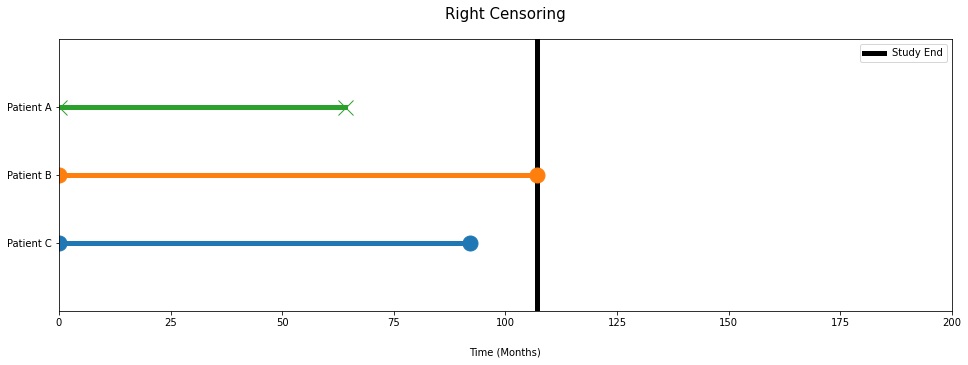

In [13]:
# Create a plot of 3 patient examples from the dataset to show survival months and censored data
fig = plt.figure(figsize=(16, 5))

plt.xlim(0, 200), plt.ylim(0, 4)
plt.axvline(107, color='black', label='Study End', linewidth=5)
plt.plot([0, 92], [1, 1], marker='o', markersize=15, linewidth=5)
plt.plot([0, 107], [2, 2], marker='o', markersize=15, linewidth=5)
plt.plot([0, 64], [3, 3], marker='x', markersize=15, linewidth=5)

plt.xlabel('Time (Months)', size=10, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.yticks([1, 2, 3], ['Patient C', 'Patient B', 'Patient A'])
plt.legend(prop={'size': 10})
plt.title('Right Censoring', size=15, pad=20)

plt.show()

 From the initial data profiling, the maximum survival months was 107, which we assume to be the study end. Patient A experiences the event at 64 months (death) before the study ends, patient B survives past the end of the study and patient C withdrew early from the study at 92 months. This is an example of 'right censored' data, which can be handled by the cox proportional-hazards model.

### Section 2B:  EDA for Categorical Variables

Below are plots showing the distribution for categorical variables in the dataset.

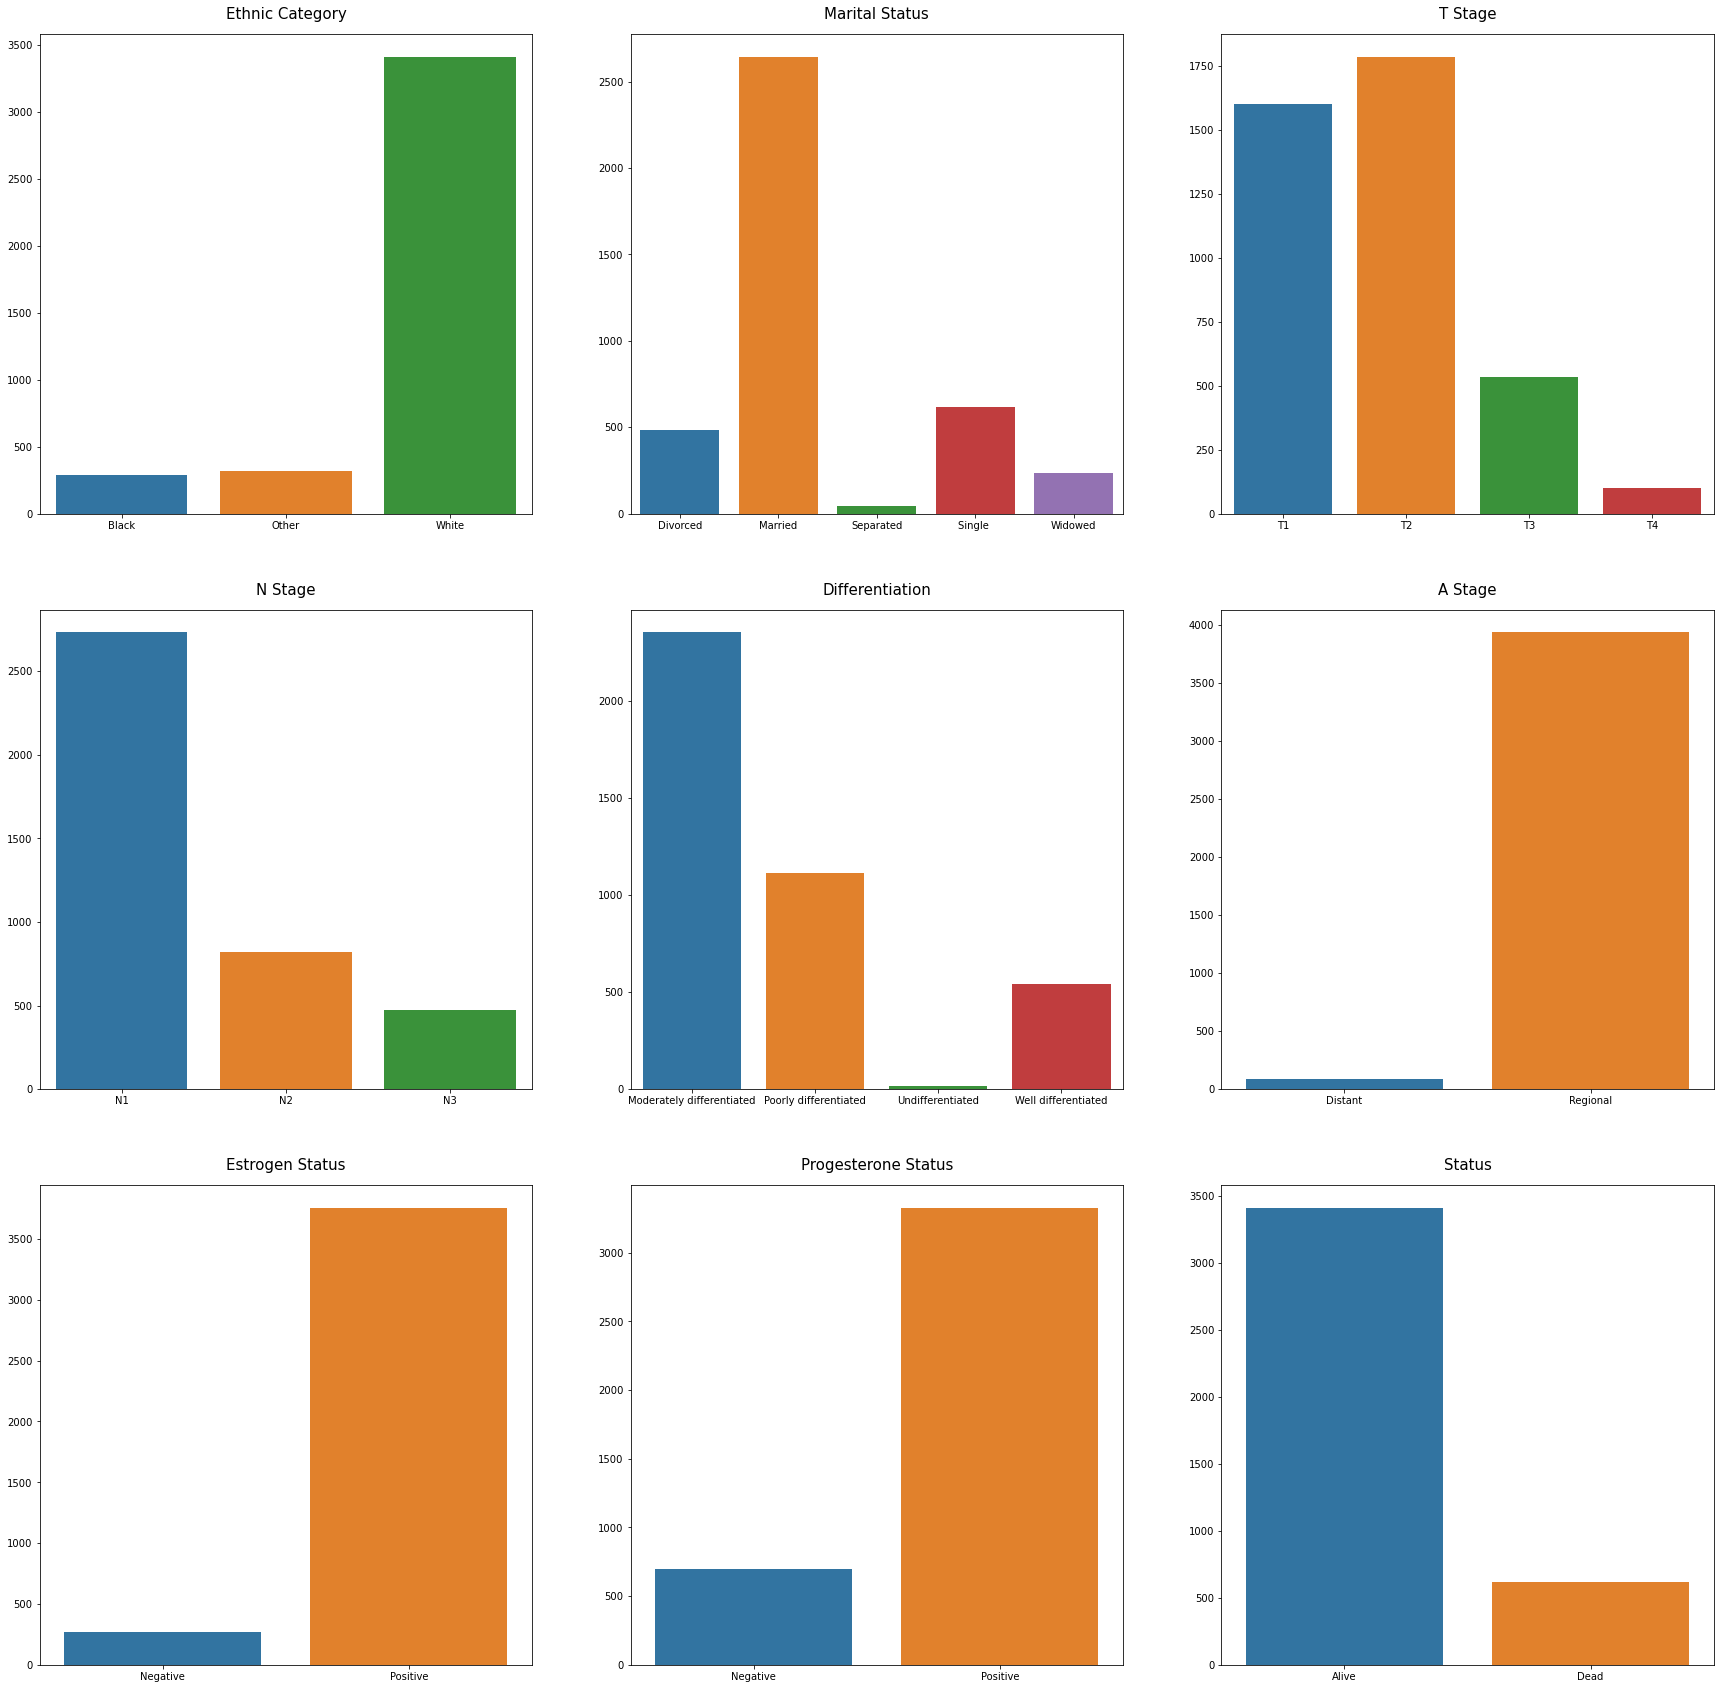

In [14]:
# EDA for categorical variables
fig, axes = plt.subplots(figsize=(30, 30), ncols=3, nrows=3)

sns.countplot(x=breast_cancer_prop['ethnicity'], ax=axes[0][0])
sns.countplot(x=breast_cancer_prop['marital_status'], ax=axes[0][1])
sns.countplot(x=breast_cancer_prop['t_stage'], ax=axes[0][2])
sns.countplot(x=breast_cancer_prop['n_stage'], ax=axes[1][0])
sns.countplot(x=breast_cancer_prop['differentiation'], ax=axes[1][1])
sns.countplot(x=breast_cancer_prop['a_stage'], ax=axes[1][2])
sns.countplot(x=breast_cancer_prop['estrogen_status'], ax=axes[2][0])
sns.countplot(x=breast_cancer_prop['progesterone_status'], ax=axes[2][1])
sns.countplot(x=breast_cancer_prop['status'], ax=axes[2][2])

for i in range(3):
    for j in range(3):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=10)
        else:
            axes[i][j].tick_params(axis='x', labelsize=10)
        axes[i][j].tick_params(axis='y', labelsize=10)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Ethnic Category', size=15, pad=15)
axes[0][1].set_title('Marital Status', size=15, pad=15)
axes[0][2].set_title('T Stage', size=15, pad=15)
axes[1][0].set_title('N Stage', size=15, pad=15)
axes[1][1].set_title('Differentiation', size=15, pad=15)
axes[1][2].set_title('A Stage', size=15, pad=15)
axes[2][0].set_title('Estrogen Status', size=15, pad=15)
axes[2][1].set_title('Progesterone Status', size=15, pad=15)
axes[2][2].set_title('Status', size=15, pad=15)

plt.show()

In relation to demographics, the predominant ethnic category is white and most patients are married. With respect to staging of the cancer, most patients are in the early T and N Stages, and in general there is not much spread to other parts of the body. Most patients have tissue that is moderately differentiated, estrogen and/or progesterone receptors tend to be present in a lot of cancers. Much of the population was alive at the end of the study or at the point of withdrawal.

### Section 2C:  EDA for Continuous Variables

Below are plots showing the distribution for continuous variables in the dataset.

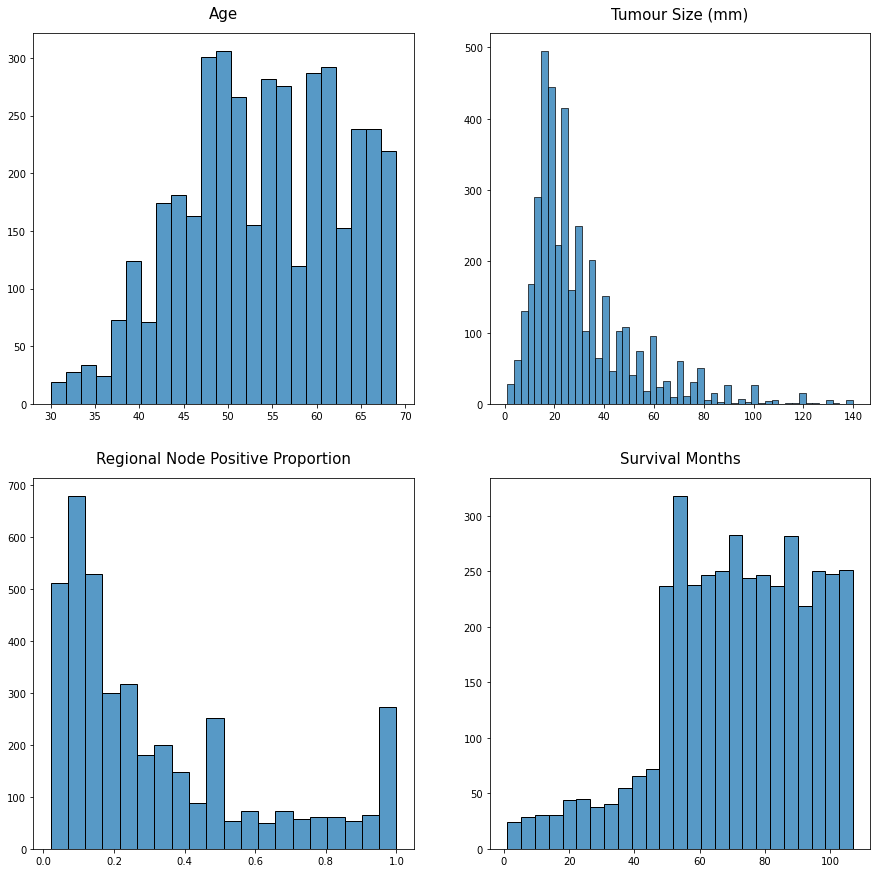

In [15]:
# EDA for continuous variables
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=2)

sns.histplot(breast_cancer_prop['age'], ax=axes[0][0])
sns.histplot(breast_cancer_prop['tumour_size'], ax=axes[0][1])
sns.histplot(breast_cancer_prop['regional_node_positive_proportion'], ax=axes[1][0])
sns.histplot(breast_cancer_prop['survival_months'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=10)
        else:
            axes[i][j].tick_params(axis='x', labelsize=10)
        axes[i][j].tick_params(axis='y', labelsize=10)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Age', size=15, pad=15)
axes[0][1].set_title('Tumour Size (mm)', size=15, pad=15)
axes[1][0].set_title('Regional Node Positive Proportion', size=15, pad=15)
axes[1][1].set_title('Survival Months', size=15, pad=15)

plt.show()

Most of the patients seemed to be diagnosed with breast cancer between the ages of 47 and 60, which is in accordance with the lower and upper quartiles of age shown earlier. The distribution of tumour size appears to be positively skewed, with many of the tumours being smaller in size. A similar trend is observed for the proportion of regional nodes that were positive, with many having a relatively lower proportion. In contrast, the survival months appear to be negatively skewed, with lots of patients surviving a relatively longer amount of time.

### Section 2D:  Correlation Matrix of the Continuous Variables

To explore the correlation between the continuous variables, a correlation matrix (heatmap) has been generated below.

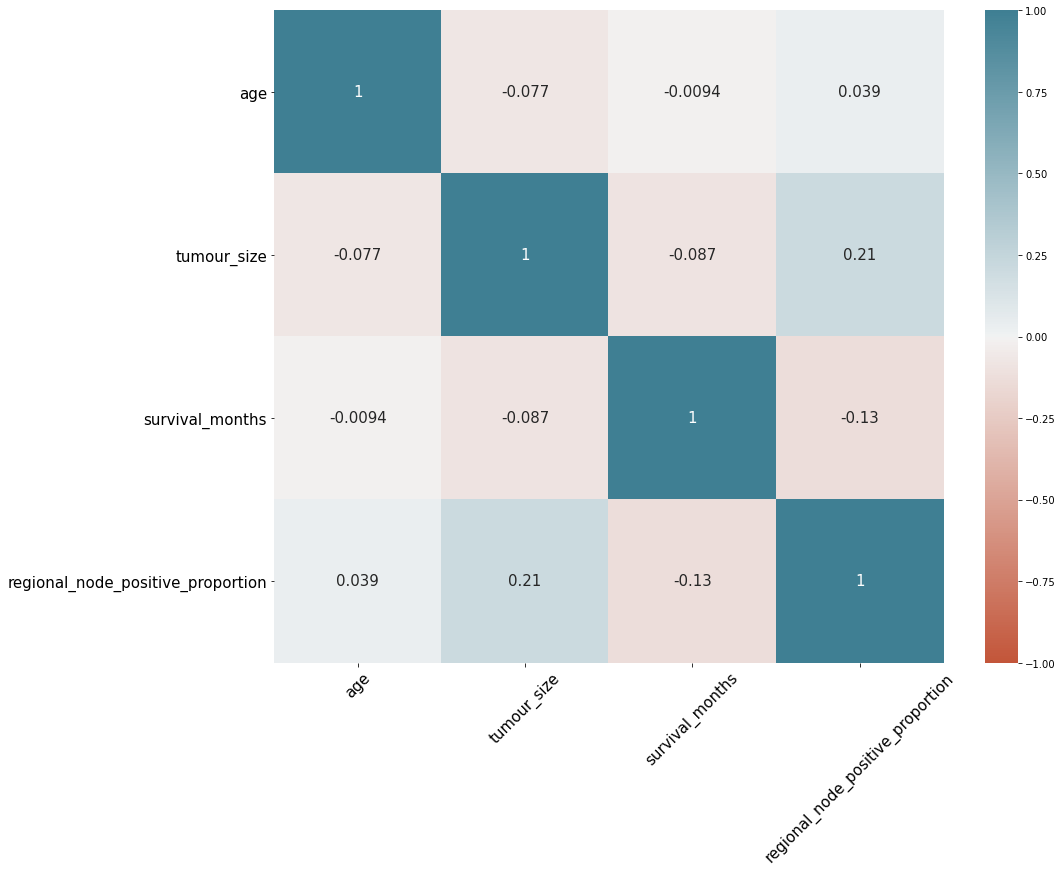

In [16]:
# Generate a heatmap for the continuous variables
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(breast_cancer_prop.corr(numeric_only=True), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

There do not appear to be any strong correlations between any of the continuous variables, with the highest being 0.21 (positive correlation) between the proportion of positive nodes and tumour size. The proportion of positive nodes is weakly negatively correlated with the survival months (-0.13). There are no multicollinearity issues, hence none of the continuous variables are dropped.

## Section 3: Creating the Prediction Model

In this section, a Cox Proportional-Hazards regression model to predict and explain breast cancer survival time will be created. The aim is to predict the probability of survival after a time t. Prior to doing so, the data will be prepared for modelling and will be split into training/test sets.

### Section 3A:  Preparing the Categorical Predictors for Modelling

Before modelling, the categorical columns must first be one-hot encoded. At the same time, one column for each one-hot encoded variable is dropped to avoid multi-collinearity issues with the data (meaning the columns would be highly correlated). Information about the dropped variables would be implied by other columns in the same category.


In [17]:
# Identifying the categorical variables
cols_to_encode = ['ethnicity','marital_status','t_stage','n_stage','differentiation', 'a_stage', 'estrogen_status', 'progesterone_status', 'status']
 

# One-hot encoding the categorical variables, with dropping of the first column which acts as a baseline
encoded_df = pd.get_dummies(breast_cancer_prop, columns=cols_to_encode, prefix=cols_to_encode, drop_first=True)

encoded_df

,age,tumour_size,survival_months,regional_node_positive_proportion,ethnicity_Other,ethnicity_White,marital_status_Married,marital_status_Separated,marital_status_Single,marital_status_Widowed,...,t_stage_T4,n_stage_N2,n_stage_N3,differentiation_Poorly differentiated,differentiation_Undifferentiated,differentiation_Well differentiated,a_stage_Regional,estrogen_status_Positive,progesterone_status_Positive,status_Dead
0,68,4,60,0.041667,0,1,1,0,0,0,...,0,0,0,1,0,0,1,1,1,0
1,50,35,62,0.357143,0,1,1,0,0,0,...,0,1,0,0,0,0,1,1,1,0
2,58,63,75,0.500000,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,1,0
3,58,18,84,0.500000,0,1,1,0,0,0,...,0,0,0,1,0,0,1,1,1,0
4,47,41,50,0.333333,0,1,1,0,0,0,...,0,0,0,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,9,49,1.000000,1,0,1,0,0,0,...,0,0,0,0,0,0,1,1,1,0
4020,56,46,69,0.571429,0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,1,0
4021,68,22,69,0.272727,0,1,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4022,58,44,72,0.090909,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0


### Section 3B:  Training and Testing Data

Here the data is randomly split into training and test sets. To evaluate the model, we reserve 20% of the data for the test set (80% will be used for model training).

In [18]:
X = encoded_df[encoded_df.columns.difference(['survival_months'])] # Get all the columns except survival_months (which is the target)
y = encoded_df['survival_months']

# 80-20 split of the data, with a fixed seed
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=50)

### Section 3C:  Grid Search

A grid search (which uses k-fold cross-validation) is performed on the training set, again using an 80-20 split (effectively creating validation sets). Several hyperparameters within the 'penalizer' and 'l1_ratio' are assessed, which assign penalties to the size of the coefficients. The best estimator and its mean score are shown below.

In [19]:
# Sklearn wrapper over the lifelines module to implement CPH model
base_class = sklearn_adapter(CoxPHFitter, event_col='status_Dead')
cph = base_class()

# Grid search with different values of penalizer and l1_ratio using the training data
clf = GridSearchCV(cph, {
   "penalizer": [1, 0.1, 0.01, 0.0001, 0],
   "l1_ratio": [0, 0.05, 0.1, 0.2, 0.3],
}, cv=5)

# Carry out grid search on the training data only (effectively creating validation sets)
clf.fit(x_train, y_train)

# Print the results of the best estimator
print(clf.best_estimator_)
print(clf.best_score_) # c-index, described in the next section

SkLearnCoxPHFitter(baseline_estimation_method='breslow', breakpoints=None,
                   knots=None, l1_ratio=0.05, n_baseline_knots=None,
                   penalizer=0.01, strata=None)
0.7423482728567459


### Section 3D:  Model Performance, Results and Interpretation

Using the hyperparameters identified in the previous section, a model is trained using the entire training set and results on the test set are obtained.

In [20]:
# Fit model with best hyperparameters to the entire training set, obtain final result on test set
CoxRegression = sklearn_adapter(CoxPHFitter, event_col='status_Dead')

sk_cph = CoxRegression(baseline_estimation_method='breslow', breakpoints=None,
                   knots=None, l1_ratio=0.05, n_baseline_knots=None,
                   penalizer=0.01, strata=None)

sk_cph.fit(x_train, y_train)
print(sk_cph)
print("The c-index on the test set is: ", sk_cph.score(x_test, y_test))

SkLearnCoxPHFitter(baseline_estimation_method='breslow', breakpoints=None,
                   knots=None, l1_ratio=0.05, n_baseline_knots=None,
                   penalizer=0.01, strata=None)
The c-index on the test set is:  0.7239440284483506


To evaluate the performance of the model, the concordance-index (or c-index) is used, which is commonly used in survival analysis as it is sensitive to censoring. It is a generalisation of the AUC, and indicates how discriminant the model is. It compares two patients at a time, to determine which one will have a shorter survival time - a higher value of the c-index indicates more reliability in this comparison. For example, if one patient is predicted to have higher risk by the model, there should be a shorter survival time for that patient. However, if both patients are censored, the pair is discarded, whereas if one patient is censored, the pair is retained only if the other patient experienced an event prior to the censoring time (i.e., they did not withdraw for other reasons).  The typical c-index for survival models is between 0.55 and 0.75. Considering that the result on the test set is 0.72, which is close to the high end of this range, the model shows good performance. Additionally, a dataframe containing values including the coefficients, p-values and confidence intervals is described below.

In [21]:
sk_cph.lifelines_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
a_stage_Regional,-0.187843,0.828745,0.203202,-0.586112,0.210425,0.556487,1.234203,0.0,-0.924416,3.552696e-01,1.493014
age,0.015021,1.015134,0.005198,0.004833,0.025209,1.004845,1.025530,0.0,2.889749,3.855499e-03,8.018867
differentiation_Poorly differentiated,0.345634,1.412886,0.095962,0.157552,0.533716,1.170642,1.705258,0.0,3.601784,3.160405e-04,11.627603
differentiation_Undifferentiated,0.743753,2.103816,0.397052,-0.034455,1.521961,0.966132,4.581200,0.0,1.873187,6.104254e-02,4.034041
differentiation_Well differentiated,-0.380653,0.683415,0.171676,-0.717132,-0.044173,0.488150,0.956788,0.0,-2.217271,2.660457e-02,5.232182
estrogen_status_Positive,-0.639673,0.527465,0.145955,-0.925740,-0.353606,0.396238,0.702151,0.0,-4.382669,1.172344e-05,16.380245
ethnicity_Other,-0.516457,0.596631,0.214928,-0.937709,-0.095205,0.391524,0.909186,0.0,-2.402927,1.626443e-02,5.942136
ethnicity_White,-0.317713,0.727812,0.138177,-0.588534,-0.046892,0.555140,0.954191,0.0,-2.299325,2.148647e-02,5.540428
marital_status_Married,-0.217305,0.804684,0.121673,-0.455780,0.021169,0.633953,1.021395,0.0,-1.785977,7.410296e-02,3.754325


In the table above, the 'coef' column represents the coefficient, and 'exp(coef)' represents the hazard ratio. The coefficients represent the change in the expected log of the hazard ratio, relative to a one unit change in a particular predictor whilst the others remain constant. The hazard ratio compares two groups - for example, using a binary predictor like 'progesterone_status_Positive', the hazard ratio compares the risk of event for patients with positive status to those with negative status. A value of the hazard ratio close to 1 indicates the predictor does not affect survival, less than 1 implies it is protective, and greater than 1 implies it is associated with decreased survival (or increased risk). Similarly, for other categorical variables that are one-hot encoded, they are relative to the baseline category. Using the example of age, the exp(coef) of 1.015 indicates a 1.5% increase in the expected hazard relative to a one year increase in age, whilst all the other factors are held constant.

<br> The following factors appear to be protective: a_stage_Regional, differentiation_Well differentiated, estrogen_status_Positive, ethnicity_Other, ethnicity_White, marital_status_Married, marital_status_Single, progesterone_status_Positive.

<br> The following factors appear to decrease survival: differentiation_Poorly differentiated, differentiation_Undifferentiated, marital_status_Separated, marital_status_Widowed, n_stage_N2, n_stage_N3, regional_node_positive_proportion, t_stage_T2, t_stage_T3, t_stage_T4.

<br> The remaining factors - age and tumour size are very close to 1 and appear to have relatively little impact on survival.

<br> Considering a p-value threshold of 0.05, the following factors are significant: age, differentiation_Poorly differentiated, differentiation_Well differentiated, estrogen_status_Positive, ethnicity_Other, ethnicity_White, marital_status_Separated, n_stage_N2, n_stage_N3, progesterone_status_Positive, regional_node_positive_proportion, t_stage_T4. It can be observed that their confidence intervals do not overlap with 1.

<br> Furthermore, a visual representation of the coefficients (log hazard ratio) is created below, with standard errors and magnitudes.

<AxesSubplot:xlabel='log(HR) (95% CI)'>

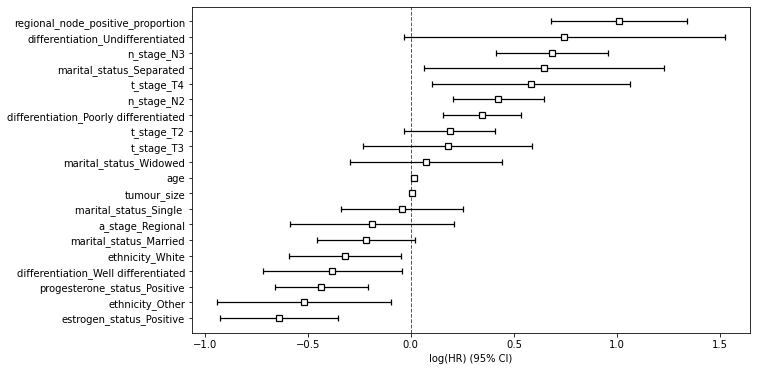

In [22]:
# Plot coefficients and their standard errors
plt.subplots(figsize = (10, 6))
sk_cph.lifelines_model.plot()

A similar trend is observed, for example we can see that the coefficients of age and tumour_size are close to 0. differentiation_Undifferentiated, regional_node_positive_proportion and n_stage_N3 have the largest positive coefficients, whereas estrogen_status_Positive, progesterone_status_Positive and ethnicity_Other have the largest negative coefficients.

<br> A plot comparing the baseline curve of the model to when a specific covariate is changed can also be generated. An example using age is shown below. 

Text(0, 0.5, 'Survival')

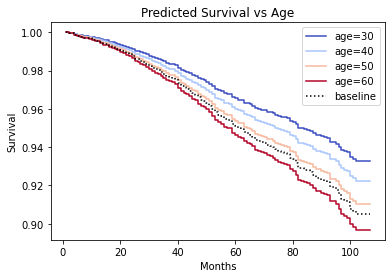

In [23]:
# Plot partial effects of age on the outcome
sk_cph.lifelines_model.plot_partial_effects_on_outcome('age', values=[30, 40, 50, 60], cmap='coolwarm')
plt.title('Predicted Survival vs Age')
plt.xlabel('Months')
plt.ylabel('Survival')

The trend is as expected; patients with earlier diagnosis demonstrate better survival. Another example using differentiation is shown below.

Text(0, 0.5, 'Survival')

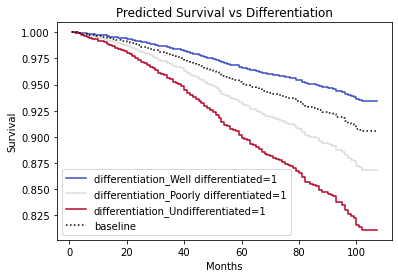

In [24]:
# Plot partial effects of differentiation on the outcome
sk_cph.lifelines_model.plot_partial_effects_on_outcome(covariates = ['differentiation_Well differentiated', 'differentiation_Poorly differentiated', 'differentiation_Undifferentiated'], values=[[1, 0, 0], [0, 1, 0], [0, 0, 1]], cmap='coolwarm', plot_baseline=True)
plt.title('Predicted Survival vs Differentiation')
plt.xlabel('Months')
plt.ylabel('Survival')

It can be seen that patients with well-differentiated cancers have the best predicted survival, followed by the baseline (moderately differentiated), poorly differentiated and undifferentiated, which is what we would expect. 

<br> An example of the survival curve using three random patients from the test set is shown below, alongside their attributes.

      a_stage_Regional  age  differentiation_Poorly differentiated  \
2337                 1   37                                      0   
1691                 1   56                                      0   
168                  1   48                                      0   

      differentiation_Undifferentiated  differentiation_Well differentiated  \
2337                                 0                                    0   
1691                                 0                                    1   
168                                  0                                    0   

      estrogen_status_Positive  ethnicity_Other  ethnicity_White  \
2337                         1                0                1   
1691                         1                0                1   
168                          1                0                1   

      marital_status_Married  marital_status_Separated  \
2337                       0                         0   
1691         

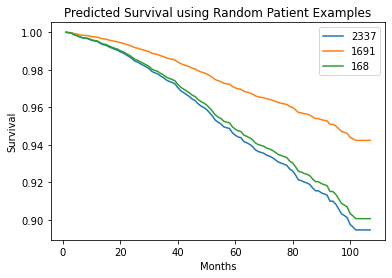

In [32]:
# Plot the predicted survival curve for 3 random patients in the test set
sk_cph.lifelines_model.predict_survival_function(x_test.iloc[1:4, :]).plot()
plt.title('Predicted Survival using Random Patient Examples')
plt.xlabel('Months')
plt.ylabel('Survival')

# Print all the patients' attributes
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(x_test.iloc[1:4, :])

Patient 1691 has much better predicted survival, whereas 168 and 2337 have similar curves. Looking at their characteristics, we can see that 1691 had a well-differentiated cancer (compared to moderately differentiated in the other two), an earlier t_stage (T1 vs T2) and much smaller tumour size which could explain this difference. However, the data for all 3 patients is censored (status_Dead = 0) so we cannot make direct comparisons using survival time.

### Section 3E:  Conclusion

In summary, several steps were carried out in the modelling process:

* Dataset definition, loading and initial exploration - the 'grade' and '6th_stage' columns were dropped as they did not appear to contribute information contained in more granular variables, 'regional_nodes_examined' and 'regional_nodes_positive' were combined into a rate. No missing data or outliers were identified.
* Exploratory data analysis - censoring was identified using patient examples, followed by distributions of categorical and continuous variables. A correlation matrix was created for continuous variables.
* Modelling and results interpretation - the data was split 80-20 into training and test sets. A grid search on the training set identified the best hyperparameters, which were then used on the entire training set. C-index on the test set indicated good performance (0.72). Coefficients and hazard ratios were explored, including identification of significant factors. Predicted survival curves were plotted to show the effect of features on the outcome.

<br> Future work could look at a wider range of variables, such as treatments (e.g., radiotherapy, chemotherapy), family history, comorbidities and gene expression data if available. The dataset also has a relatively limited number of observations, which could lead to variability in results depending on the data splits. 